## Load the data and simple visualisation

In [2]:
from load_oxford_flowers102 import load_oxford_flowers102
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import nets

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [3]:

train_data, validation_data, test_data, class_names = load_oxford_flowers102(imsize=96, fine=False)
y_train = train_data["labels"]
y_test = test_data["labels"]
x_train = train_data["images"]
x_test = test_data["images"]
x_valid = validation_data["images"]
y_valid = validation_data["labels"]
# SEED = 1
input_shape = (96, 96, 3)
n_classes = len(class_names)

In [4]:
def class_proportions(labels, n_classes):
    proportions = np.zeros(n_classes)
    
    # Count the occurrences of each class
    for label in labels:
        proportions[label] += 1
    
    # Calculate proportions
    # proportions = class_counts / len(labels)
    
    # Create a dictionary with labels as keys and proportions as values
    proportion_dict = {label: proportion for label, proportion in enumerate(proportions)}
    
    return proportion_dict

In [5]:
Y_train = tf.keras.utils.to_categorical(y_train)
samples = class_proportions(y_train, n_classes)
total=sum(samples.values())

optimal_bias = tf.constant_initializer([np.log(samples[i]/total) for i in range(10)])
opt_bias_model = nets.simple_cnn(input_shape, n_classes, initial_bias=optimal_bias)
opt_bias_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

default_bias = initial_bias = tf.constant_initializer([0 for i in range(10)])
normal_model = nets.simple_cnn(input_shape, n_classes, initial_bias=default_bias)
normal_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

samples

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-15 11:23:39.081293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 11:23:39.373269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 11:23:39.

{0: 115.0,
 1: 20.0,
 2: 164.0,
 3: 293.0,
 4: 368.0,
 5: 201.0,
 6: 136.0,
 7: 103.0,
 8: 291.0,
 9: 97.0}

In [6]:
exp = -sum([n_i/total * np.log(1/10) for n_i in samples.values()])

# actual loss
pretrain_preds = normal_model.predict(x_train, verbose=False)
act = np.mean(tf.keras.losses.categorical_crossentropy(Y_train, pretrain_preds))

print("Non-optimized model")
print(f"    Expected pre-training loss {exp}")
print(f"    Actual pre-training loss {act}")

I0000 00:00:1713137019.750662 1176839 service.cc:145] XLA service 0x7fdd88004d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713137019.750680 1176839 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-04-15 11:23:39.787597: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 11:23:39.947059: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1713137020.913017 1176839 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Non-optimized model
    Expected pre-training loss 2.302585092994045
    Actual pre-training loss 13.377124786376953


In [7]:
# expected loss from using an optimal initialization
exp = -sum([n_i/total * np.log(n_i/total) for n_i in samples.values()])

# actual loss
pretrain_preds = opt_bias_model.predict(x_train, verbose=False)
act = np.mean(tf.keras.losses.categorical_crossentropy(Y_train, pretrain_preds))

print("Non-optimized model")
print(f"    Expected pre-training loss {exp}")
print(f"    Actual pre-training loss {act}")


Non-optimized model
    Expected pre-training loss 2.1272357843052987
    Actual pre-training loss 11.828559875488281


In [8]:
# Define this callback to have access to training loss at every batch

class BatchLossCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))

In [9]:
epochs = 1
batch_size = 32

normal_callback = BatchLossCallback()
normal_history = normal_model.fit(x_train, 
                                  y_train, 
                                  batch_size=batch_size, 
                                  epochs=epochs, 
                                  callbacks=[normal_callback])

opt_bias_callback = BatchLossCallback()
opt_bias_history = opt_bias_model.fit(x_train, 
                                      y_train, 
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      callbacks=[opt_bias_callback])

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1850 - loss: 152.5623
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2137 - loss: 108.1214


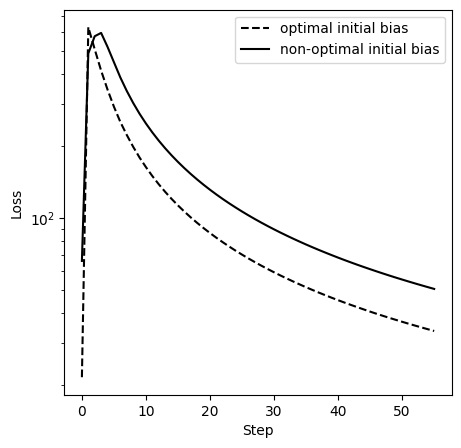

In [10]:

plt.figure(figsize=(5, 5))
plt.plot(opt_bias_callback.batch_losses, 'k--', label="optimal initial bias")
plt.plot(normal_callback.batch_losses, 'k-', label="non-optimal initial bias")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale('log')  # Setting y-axis to log scale
plt.savefig("opt-vs-normal-loss.svg", bbox_inches="tight", transparent=True)


small difference.

but over a large number of epochs:

In [11]:
epochs = 20
batch_size = 32

normal_callback = BatchLossCallback()
normal_history = normal_model.fit(x_train, 
                                  y_train, 
                                  batch_size=batch_size, 
                                  epochs=epochs, 
                                  callbacks=[normal_callback])

opt_bias_callback = BatchLossCallback()
opt_bias_history = opt_bias_model.fit(x_train, 
                                      y_train, 
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      callbacks=[opt_bias_callback])

Epoch 1/20


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5407 - loss: 1.4015
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7660 - loss: 0.6938
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9038 - loss: 0.2982
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9640 - loss: 0.1353
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9797 - loss: 0.0829
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9788 - loss: 0.0763
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9831 - loss: 0.0611
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.0747
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9788 - loss: 0.0773
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.0656
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9668 - loss: 0.1187
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9761 - loss: 0.0850


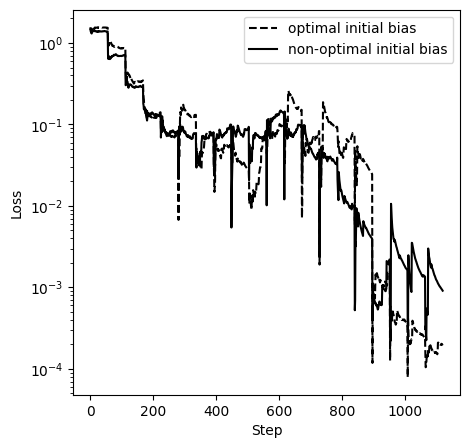

In [12]:
plt.figure(figsize=(5, 5))
plt.plot(opt_bias_callback.batch_losses, 'k--', label="optimal initial bias")
plt.plot(normal_callback.batch_losses, 'k-', label="non-optimal initial bias")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale('log')  # Setting y-axis to log scale
plt.savefig("opt-vs-normal-loss.svg", bbox_inches="tight", transparent=True)


From the graph we cant really say either performs better